In [2]:
!nvidia-smi

Mon Aug 21 16:49:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   35C    P8              20W / 170W |    940MiB / 12288MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
HOME = os.getcwd()
print(HOME)

d:\airport\vlm-lf


In [4]:
CONFIG_PATH = os.path.join(HOME, 'GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py')
print(CONFIG_PATH, "; exists:", os.path.isfile(CONFIG_PATH))

d:\airport\vlm-lf\GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exists: True


In [5]:
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "GroundingDINO/weights", WEIGHTS_NAME)

from groundingdino.util.inference import load_model, load_image, predict, annotate
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

c:\Users\s.srivastava\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3528.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [6]:
import matplotlib.pyplot as plt
import cv2
def display_bbox(boxes, image):
    """
    boxes: list of boxes, each box is a list of 4 numbers: x1, y1, x2, y2
    image: a numpy array of shape (m, n, 3), the target image
    """
    image = image.copy()
    # print(type(boxes[0][0]))
    # return
    for box in boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    plt.axis('off')
    plt.imshow(image)

In [7]:
IMAGE_NAME = "man_with_suitcase.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)
image_source, image = load_image(IMAGE_PATH)
print(image_source)

[[[30 30 28]
  [29 29 27]
  [30 30 28]
  ...
  [31 31 31]
  [32 32 32]
  [31 31 31]]

 [[32 31 29]
  [34 33 31]
  [35 34 32]
  ...
  [33 32 30]
  [24 23 21]
  [31 31 31]]

 [[36 32 31]
  [35 31 30]
  [33 29 28]
  ...
  [34 30 27]
  [43 39 36]
  [32 31 29]]

 ...

 [[43 38 34]
  [43 38 34]
  [43 38 34]
  ...
  [33 28 25]
  [32 28 25]
  [32 30 31]]

 [[42 37 33]
  [42 37 33]
  [42 37 33]
  ...
  [31 26 23]
  [30 26 23]
  [32 30 31]]

 [[41 36 32]
  [41 36 32]
  [41 36 32]
  ...
  [26 21 18]
  [25 21 18]
  [32 30 31]]]


c:\Users\s.srivastava\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\s.srivastava\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\checkpoint.py:428: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\s.srivastava\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


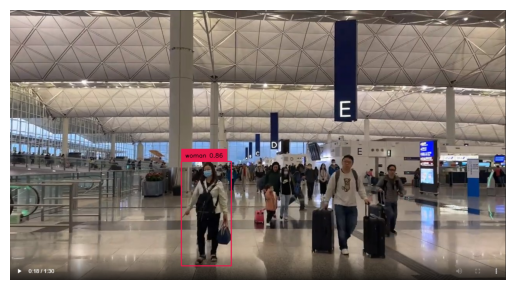

In [8]:
TEXT_PROMPT = "woman with black backpack"
BOX_TRESHOLD = 0.4
TEXT_TRESHOLD = 0.25

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(annotated_frame)

In [13]:
import groundingdino.datasets.transforms as T
import numpy as np
from PIL import Image
def load_frame(frame):
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    # image_source = Image.open(frame).convert("RGB")
    image = np.asarray(frame)
    frame_image = Image.fromarray(frame)
    image_transformed, _ = transform(frame_image, None)
    return image, image_transformed

In [16]:

TEXT_PROMPT = "woman with black backpack"
video = cv2.VideoCapture('data/hong_kong_airport_demo_data.mp4')
video_wrtier = cv2.VideoWriter('results/hong_kong_airport_demo_data_dino.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 30, (int(video.get(3)),int(video.get(4))))
framecount = 0
while video.isOpened():
    ret, frame = video.read()
    # print(frame)
    # exit()
    if not ret:
        break
    cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    if framecount % 5 == 0:
        image_source, image = load_frame(frame)
        boxes, logits, phrases = predict(
            model=model, 
            image=image, 
            caption=TEXT_PROMPT, 
            box_threshold=0.4, 
            text_threshold=0.25
        )
        annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
        video_wrtier.write(annotated_frame)
    else:
        video_wrtier.write(frame)
    framecount += 1
video.release()
video_wrtier.release()

KeyboardInterrupt: 